In [1]:
from datetime import date
today = date.today()

In [2]:
#stock = ['SPY', 'GLD', 'SPLB', 'EEM', 'QQQ', 'SLV', 'HYG', 'VWO', 'TLT', 'FXI']
stock = ['SPY']
sampling = ['daily', 'weekly'][0]
aggregation = ['last_day', 'mean'][0]
#stock = ['VTI', 'VEU', 'VNQ', 'BND', 'GSG']
date_start = '1993-01-01'
date_end = today.strftime("%Y-%m-%d")

In [3]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_datareader as pdr
import statsmodels.api as sm
import scipy.stats as scs

In [4]:
combined_data = []
for i in range(len(stock)):
    df = pdr.DataReader(stock[i], 
                       start=date_start, 
                       end=date_end, 
                       data_source='yahoo')
    name = stock[i]
    df_stock = df[['Adj Close']]
    df_stock = df_stock.rename(columns={"Adj Close" : name})
    if i > 0:
        combined_data = pd.concat([combined_data, df_stock], axis = 1)
    else:
        combined_data = df_stock
        
    
    #combined_data.append(df_stock)
    #combined_data.append(df_stock)
    #combined_data = pd.concat([combined_data, df_stock], axis=1, join="inner" )
    #df1.append(df4, ignore_index=True, sort=False)
    #result = pd.concat([df1, df4], axis=1, join="inner")
if sampling == 'weekly':
    if aggregation == 'last_day':
        combined_data = combined_data.resample('W').agg('last')
    elif aggregation == "mean":
        combined_data = combined_data.resample('W').agg('mean')

In [5]:
combined_data

,SPY
Date,
1993-01-29,25.968958
1993-02-01,26.153660
1993-02-02,26.209057
1993-02-03,26.486113
1993-02-04,26.596937
...,...
2021-02-24,391.769989
2021-02-25,382.329987
2021-02-26,380.359985


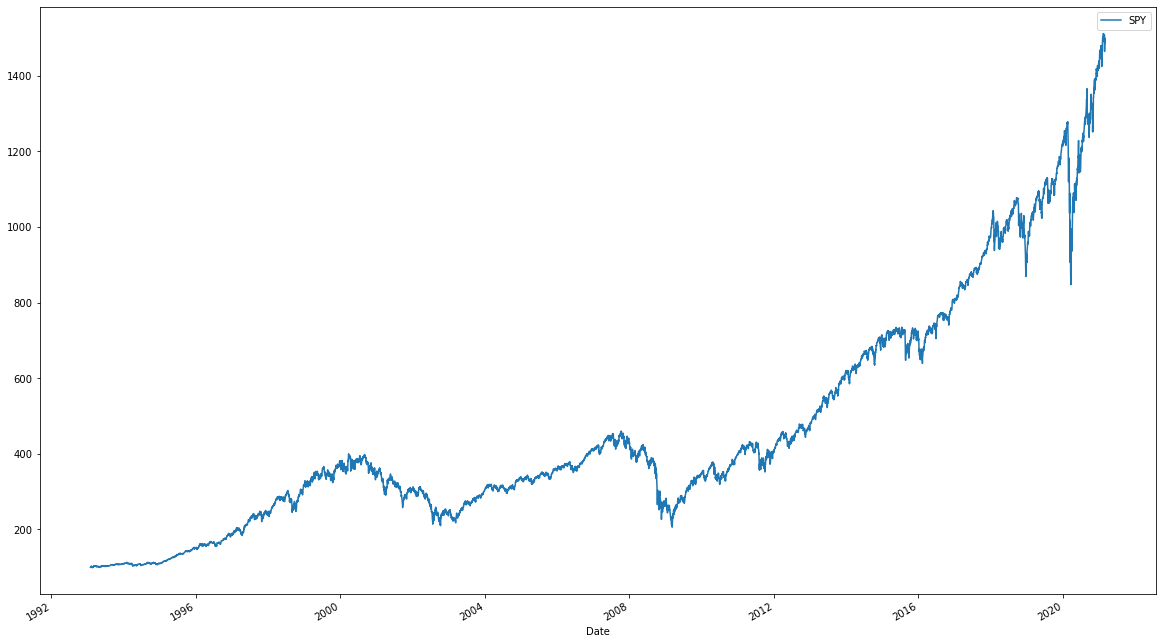

In [6]:
(combined_data / combined_data.iloc[0] * 100).plot(figsize=(20, 12))

In [7]:
combined_data['return'] = np.log(combined_data / combined_data.shift(1))
combined_data['direction'] = np.where(combined_data['return'] > 0, 1, 0)
combined_data.dropna(inplace=True)
combined_data.head()

,SPY,return,direction
Date,,,
1993-02-01,26.153660,0.007087,1
1993-02-02,26.209057,0.002116,1
1993-02-03,26.486113,0.010516,1
1993-02-04,26.596937,0.004176,1
1993-02-05,26.578478,-0.000694,0


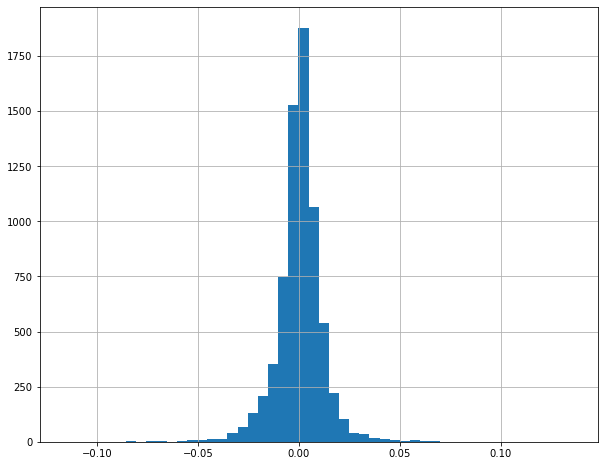

In [8]:
combined_data['return'].hist(bins=50, figsize=(10, 8));

# Feature Engineering

In [9]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    combined_data[col] = combined_data['return'].shift(lag)
    cols.append(col)
combined_data.dropna(inplace=True)

In [10]:
import ta
from ta.volatility import BollingerBands

In [11]:
indicator_bb = BollingerBands(close=combined_data['SPY'], window=20, window_dev=2)
combined_data['bb_bbm'] = indicator_bb.bollinger_mavg()
combined_data['bb_bbh'] = indicator_bb.bollinger_hband()
combined_data['bb_bbl'] = indicator_bb.bollinger_lband()

In [12]:
from ta.trend import MACD

In [13]:
indicator_macd = MACD(close = combined_data['SPY'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False)
combined_data['macd'] = indicator_macd.macd()
combined_data['macd_diff'] = indicator_macd.macd_diff()
combined_data['macd_signal'] = indicator_macd.macd_signal()

In [14]:
combined_data['momentum'] = combined_data['return'].rolling(5).mean().shift(1)
combined_data['volatility'] = combined_data['return'].rolling(20).std().shift(1)
combined_data['distance'] = (combined_data[stock] - combined_data[stock].rolling(50).mean()).shift(1)

In [15]:
combined_data.dropna(inplace=True)
combined_data

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm,bb_bbh,bb_bbl,macd,macd_diff,macd_signal,momentum,volatility,distance
Date,,,,,,,,,,,,,,,,,
1993-04-21,26.425627,-0.000703,0,-0.004900,-0.004181,0.000000,0.000000,-0.001390,26.579659,26.994298,26.165021,-0.014692,-0.012912,-0.001780,-0.002094,0.006664,-0.044106
1993-04-22,26.091602,-0.012721,0,-0.000703,-0.004900,-0.004181,0.000000,0.000000,26.551824,27.016068,26.087579,-0.050116,-0.038669,-0.011447,-0.001957,0.006641,-0.059621
1993-04-23,25.980268,-0.004276,0,-0.012721,-0.000703,-0.004900,-0.004181,0.000000,26.510070,27.019968,26.000172,-0.086180,-0.059786,-0.026394,-0.004501,0.007186,-0.387602
1993-04-26,25.776127,-0.007889,0,-0.004276,-0.012721,-0.000703,-0.004900,-0.004181,26.465533,27.061250,25.869816,-0.129738,-0.082675,-0.047063,-0.005356,0.007006,-0.489927
1993-04-27,26.054495,0.010742,1,-0.007889,-0.004276,-0.012721,-0.000703,-0.004900,26.429346,27.032567,25.826125,-0.140180,-0.074494,-0.065686,-0.006098,0.007095,-0.678391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,386.078500,399.272681,372.884319,3.510671,-0.434931,3.945602,-0.002462,0.009920,9.025182
2021-02-25,382.329987,-0.024391,0,0.010959,0.001214,-0.007721,-0.001768,-0.004265,386.474500,398.682639,374.266360,2.722356,-0.978597,3.700953,-0.000316,0.010181,12.763240
2021-02-26,380.359985,-0.005166,0,-0.024391,0.010959,0.001214,-0.007721,-0.001768,386.610999,398.476772,374.745225,1.916554,-1.427519,3.344073,-0.004341,0.010134,2.971542


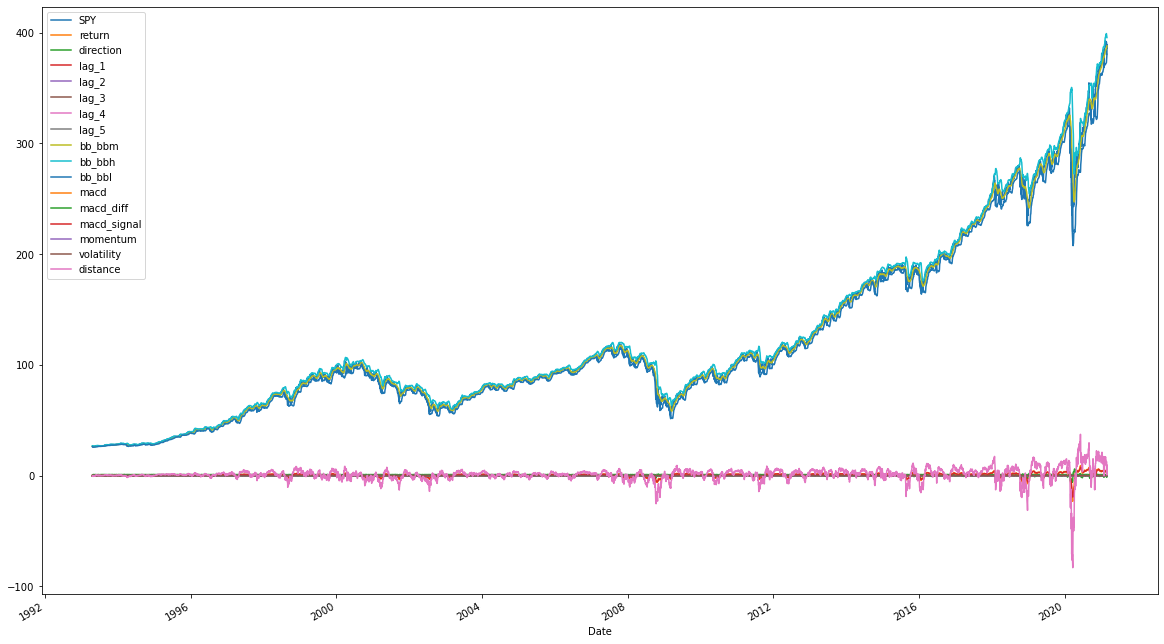

In [16]:
combined_data.plot(figsize=(20, 12))

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [18]:
cols = list(combined_data.columns)

In [19]:
cols = cols[3:]
cols

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'bb_bbm',
 'bb_bbh',
 'bb_bbl',
 'macd',
 'macd_diff',
 'macd_signal',
 'momentum',
 'volatility',
 'distance']

In [20]:
X = combined_data[cols]

In [21]:
y = combined_data['direction']

In [22]:
split = int(0.7*len(combined_data))

In [23]:
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [24]:
clf = RandomForestClassifier(random_state=5)

In [25]:
model = clf.fit(X_train, y_train)

In [26]:
from sklearn.metrics import accuracy_score
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

Correct Prediction (%):  54.79582146248813


In [27]:
cross_val = cross_val_score(model, X, y, scoring='accuracy', cv=10)
cross_val
cross_val.mean()

0.5158989396507228

In [28]:
from sklearn.metrics import classification_report
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.49      0.67      0.57       931
           1       0.63      0.45      0.53      1175

    accuracy                           0.55      2106
   macro avg       0.56      0.56      0.55      2106
weighted avg       0.57      0.55      0.54      2106



In [29]:
combined_data['Predicted_Signal'] = model.predict(X)
combined_data['Original_SP_returns'] = combined_data['return']
Cumulative_originalSP500_returns = np.cumsum(combined_data[split:]['Original_SP_returns']).apply(np.exp)
combined_data['Strategy_Returns'] = combined_data['Original_SP_returns']* combined_data['Predicted_Signal']
Cumulative_Strategy_returns = np.cumsum(combined_data[split:]['Strategy_Returns']).apply(np.exp)

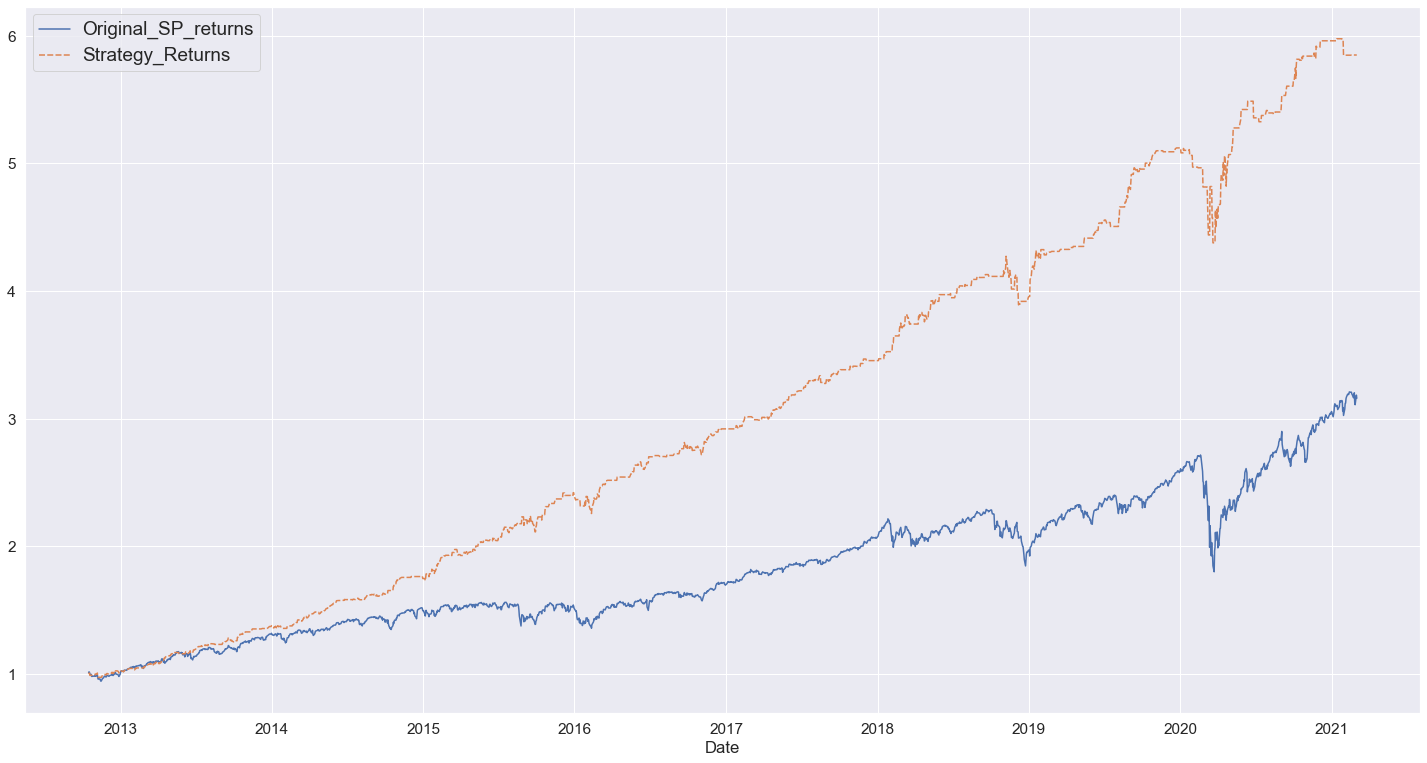

In [30]:
newdf = pd.concat([Cumulative_originalSP500_returns, Cumulative_Strategy_returns], axis=1)
 
 
#Graph plotting
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
 
plt.figure(figsize=(25, 13))
sns.set(font_scale=1.4) 
ax = sns.lineplot(data=newdf)
plt.setp(ax.get_legend().get_texts(), fontsize='19')
plt.savefig('returns.png', dpi=300)

# Grid Search

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
param_grid = [
    {'n_estimators': [10,40, 50, 60, 100],
    'max_depth': [4, 5, 6, 10],
    'max_features': [4,6,8,10]
    }
]

In [33]:
clf2 = RandomForestClassifier(random_state=5)

In [34]:
grid_search = GridSearchCV(clf2, param_grid, cv = 5, scoring = 'accuracy', verbose = 3)

In [35]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END ...max_depth=4, max_features=4, n_estimators=10; total time=   0.0s
[CV 2/5] END ...max_depth=4, max_features=4, n_estimators=10; total time=   0.0s
[CV 3/5] END ...max_depth=4, max_features=4, n_estimators=10; total time=   0.0s
[CV 4/5] END ...max_depth=4, max_features=4, n_estimators=10; total time=   0.0s
[CV 5/5] END ...max_depth=4, max_features=4, n_estimators=10; total time=   0.0s
[CV 1/5] END ...max_depth=4, max_features=4, n_estimators=40; total time=   0.1s
[CV 2/5] END ...max_depth=4, max_features=4, n_estimators=40; total time=   0.1s
[CV 3/5] END ...max_depth=4, max_features=4, n_estimators=40; total time=   0.1s
[CV 4/5] END ...max_depth=4, max_features=4, n_estimators=40; total time=   0.1s
[CV 5/5] END ...max_depth=4, max_features=4, n_estimators=40; total time=   0.1s
[CV 1/5] END ...max_depth=4, max_features=4, n_estimators=50; total time=   0.1s
[CV 2/5] END ...max_depth=4, max_features=4, n_

[CV 3/5] END ...max_depth=5, max_features=4, n_estimators=10; total time=   0.0s
[CV 4/5] END ...max_depth=5, max_features=4, n_estimators=10; total time=   0.0s
[CV 5/5] END ...max_depth=5, max_features=4, n_estimators=10; total time=   0.0s
[CV 1/5] END ...max_depth=5, max_features=4, n_estimators=40; total time=   0.1s
[CV 2/5] END ...max_depth=5, max_features=4, n_estimators=40; total time=   0.1s
[CV 3/5] END ...max_depth=5, max_features=4, n_estimators=40; total time=   0.1s
[CV 4/5] END ...max_depth=5, max_features=4, n_estimators=40; total time=   0.1s
[CV 5/5] END ...max_depth=5, max_features=4, n_estimators=40; total time=   0.1s
[CV 1/5] END ...max_depth=5, max_features=4, n_estimators=50; total time=   0.2s
[CV 2/5] END ...max_depth=5, max_features=4, n_estimators=50; total time=   0.2s
[CV 3/5] END ...max_depth=5, max_features=4, n_estimators=50; total time=   0.2s
[CV 4/5] END ...max_depth=5, max_features=4, n_estimators=50; total time=   0.2s
[CV 5/5] END ...max_depth=5,

[CV 1/5] END ...max_depth=6, max_features=4, n_estimators=40; total time=   0.1s
[CV 2/5] END ...max_depth=6, max_features=4, n_estimators=40; total time=   0.1s
[CV 3/5] END ...max_depth=6, max_features=4, n_estimators=40; total time=   0.1s
[CV 4/5] END ...max_depth=6, max_features=4, n_estimators=40; total time=   0.1s
[CV 5/5] END ...max_depth=6, max_features=4, n_estimators=40; total time=   0.1s
[CV 1/5] END ...max_depth=6, max_features=4, n_estimators=50; total time=   0.2s
[CV 2/5] END ...max_depth=6, max_features=4, n_estimators=50; total time=   0.2s
[CV 3/5] END ...max_depth=6, max_features=4, n_estimators=50; total time=   0.2s
[CV 4/5] END ...max_depth=6, max_features=4, n_estimators=50; total time=   0.2s
[CV 5/5] END ...max_depth=6, max_features=4, n_estimators=50; total time=   0.2s
[CV 1/5] END ...max_depth=6, max_features=4, n_estimators=60; total time=   0.2s
[CV 2/5] END ...max_depth=6, max_features=4, n_estimators=60; total time=   0.3s
[CV 3/5] END ...max_depth=6,

[CV 3/5] END ..max_depth=10, max_features=4, n_estimators=40; total time=   0.2s
[CV 4/5] END ..max_depth=10, max_features=4, n_estimators=40; total time=   0.3s
[CV 5/5] END ..max_depth=10, max_features=4, n_estimators=40; total time=   0.2s
[CV 1/5] END ..max_depth=10, max_features=4, n_estimators=50; total time=   0.3s
[CV 2/5] END ..max_depth=10, max_features=4, n_estimators=50; total time=   0.3s
[CV 3/5] END ..max_depth=10, max_features=4, n_estimators=50; total time=   0.3s
[CV 4/5] END ..max_depth=10, max_features=4, n_estimators=50; total time=   0.3s
[CV 5/5] END ..max_depth=10, max_features=4, n_estimators=50; total time=   0.3s
[CV 1/5] END ..max_depth=10, max_features=4, n_estimators=60; total time=   0.4s
[CV 2/5] END ..max_depth=10, max_features=4, n_estimators=60; total time=   0.4s
[CV 3/5] END ..max_depth=10, max_features=4, n_estimators=60; total time=   0.4s
[CV 4/5] END ..max_depth=10, max_features=4, n_estimators=60; total time=   0.4s
[CV 5/5] END ..max_depth=10,

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
             param_grid=[{'max_depth': [4, 5, 6, 10],
                          'max_features': [4, 6, 8, 10],
                          'n_estimators': [10, 40, 50, 60, 100]}],
             scoring='accuracy', verbose=3)

In [36]:
grid_search.best_params_

{'max_depth': 6, 'max_features': 6, 'n_estimators': 40}

In [37]:
clf_opt = RandomForestClassifier(max_depth = 6, max_features = 6, n_estimators = 10,random_state=5)

In [38]:
model = clf_opt.fit(X_train, y_train)

In [39]:
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

Correct Prediction (%):  59.21177587844254


In [40]:
cross_val = cross_val_score(model, X, y, scoring='accuracy', cv=10)
cross_val
cross_val.mean()

0.5629170375247408

In [41]:
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.55      0.45      0.49       931
           1       0.62      0.71      0.66      1175

    accuracy                           0.59      2106
   macro avg       0.58      0.58      0.58      2106
weighted avg       0.59      0.59      0.59      2106



In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

Confusion Matrix
[[1230 1061]
 [ 471 2149]]

Accuracy
0.6880472408878029


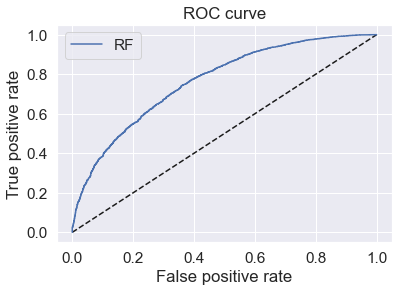

In [43]:
# Performance Metrics
y_pred_rf = clf_opt.predict_proba(X_train)[:, 1]
y_pred = clf_opt.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

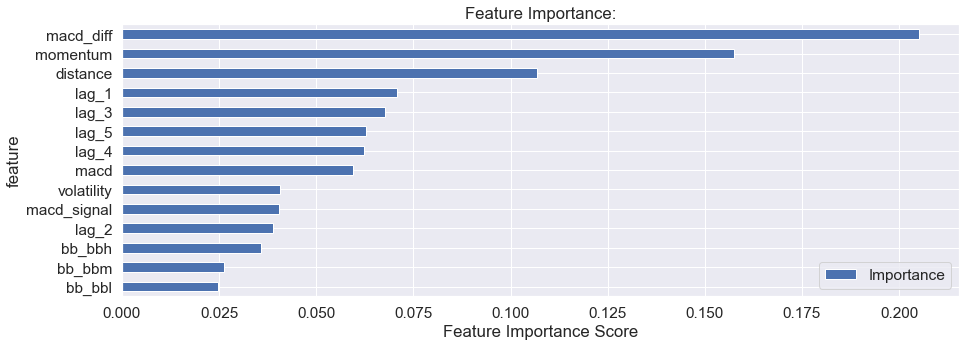

In [44]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':clf_opt.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

              precision    recall  f1-score   support

           0       0.55      0.45      0.49       931
           1       0.62      0.71      0.66      1175

    accuracy                           0.59      2106
   macro avg       0.58      0.58      0.58      2106
weighted avg       0.59      0.59      0.59      2106

Confusion Matrix
[[418 513]
 [346 829]]

Accuracy
0.5921177587844254


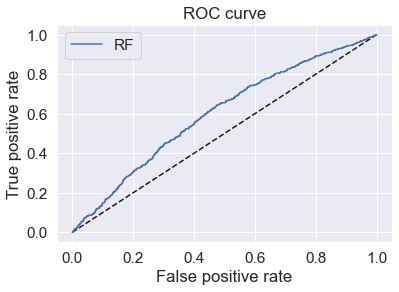

In [45]:
# Performance Metrics
y_pred_rf = clf_opt.predict_proba(X_test)[:, 1]
y_pred = clf_opt.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [46]:
combined_data['Predicted_Signal'] = model.predict(X)
combined_data['Original_SP_returns'] = combined_data['return']
Cumulative_originalSP500_returns = np.cumsum(combined_data[split:]['Original_SP_returns']).apply(np.exp)
combined_data['Strategy_Returns'] = combined_data['Original_SP_returns']* combined_data['Predicted_Signal']
Cumulative_Strategy_returns = np.cumsum(combined_data[split:]['Strategy_Returns']).apply(np.exp)

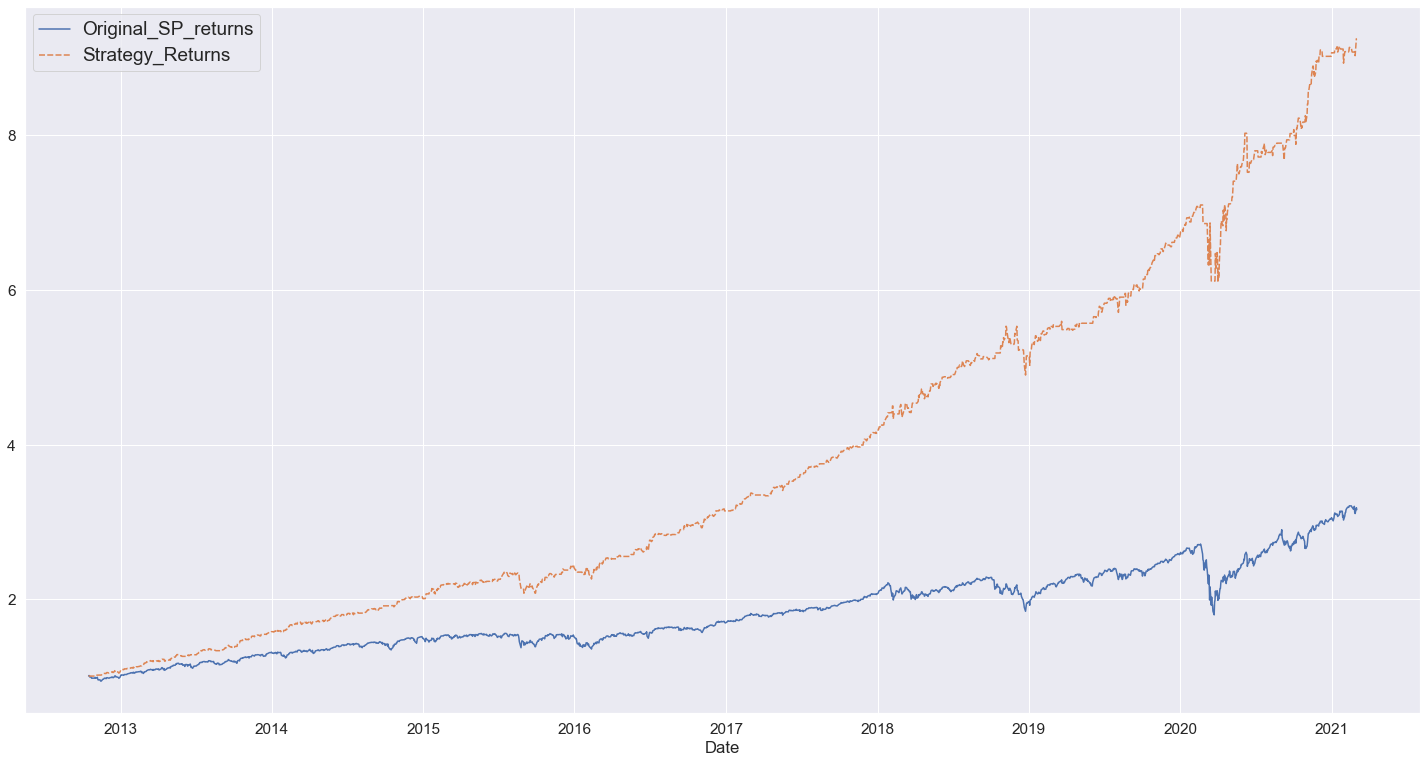

In [47]:
newdf = pd.concat([Cumulative_originalSP500_returns, Cumulative_Strategy_returns], axis=1)

 
plt.figure(figsize=(25, 13))
sns.set(font_scale=1.4) 
ax = sns.lineplot(data=newdf)
plt.setp(ax.get_legend().get_texts(), fontsize='19')
plt.savefig('returns.png', dpi=300)

In [48]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


Start date,2013-01-02
End date,2021-03-02
Total months,97
,Backtest
Annual return,29.324%
Cumulative returns,714.184%
Annual volatility,12.577%
Sharpe ratio,2.11
Calmar ratio,1.85
Stability,0.99
Max drawdown,-15.841%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.84,2020-02-24,2020-04-01,2020-05-08,55
1,12.18,2015-07-20,2015-09-28,2015-12-04,100
2,11.63,2018-11-07,2018-12-24,2019-03-21,97
3,7.75,2015-12-29,2016-02-11,2016-03-02,47
4,6.46,2020-06-09,2020-06-11,2020-10-01,83


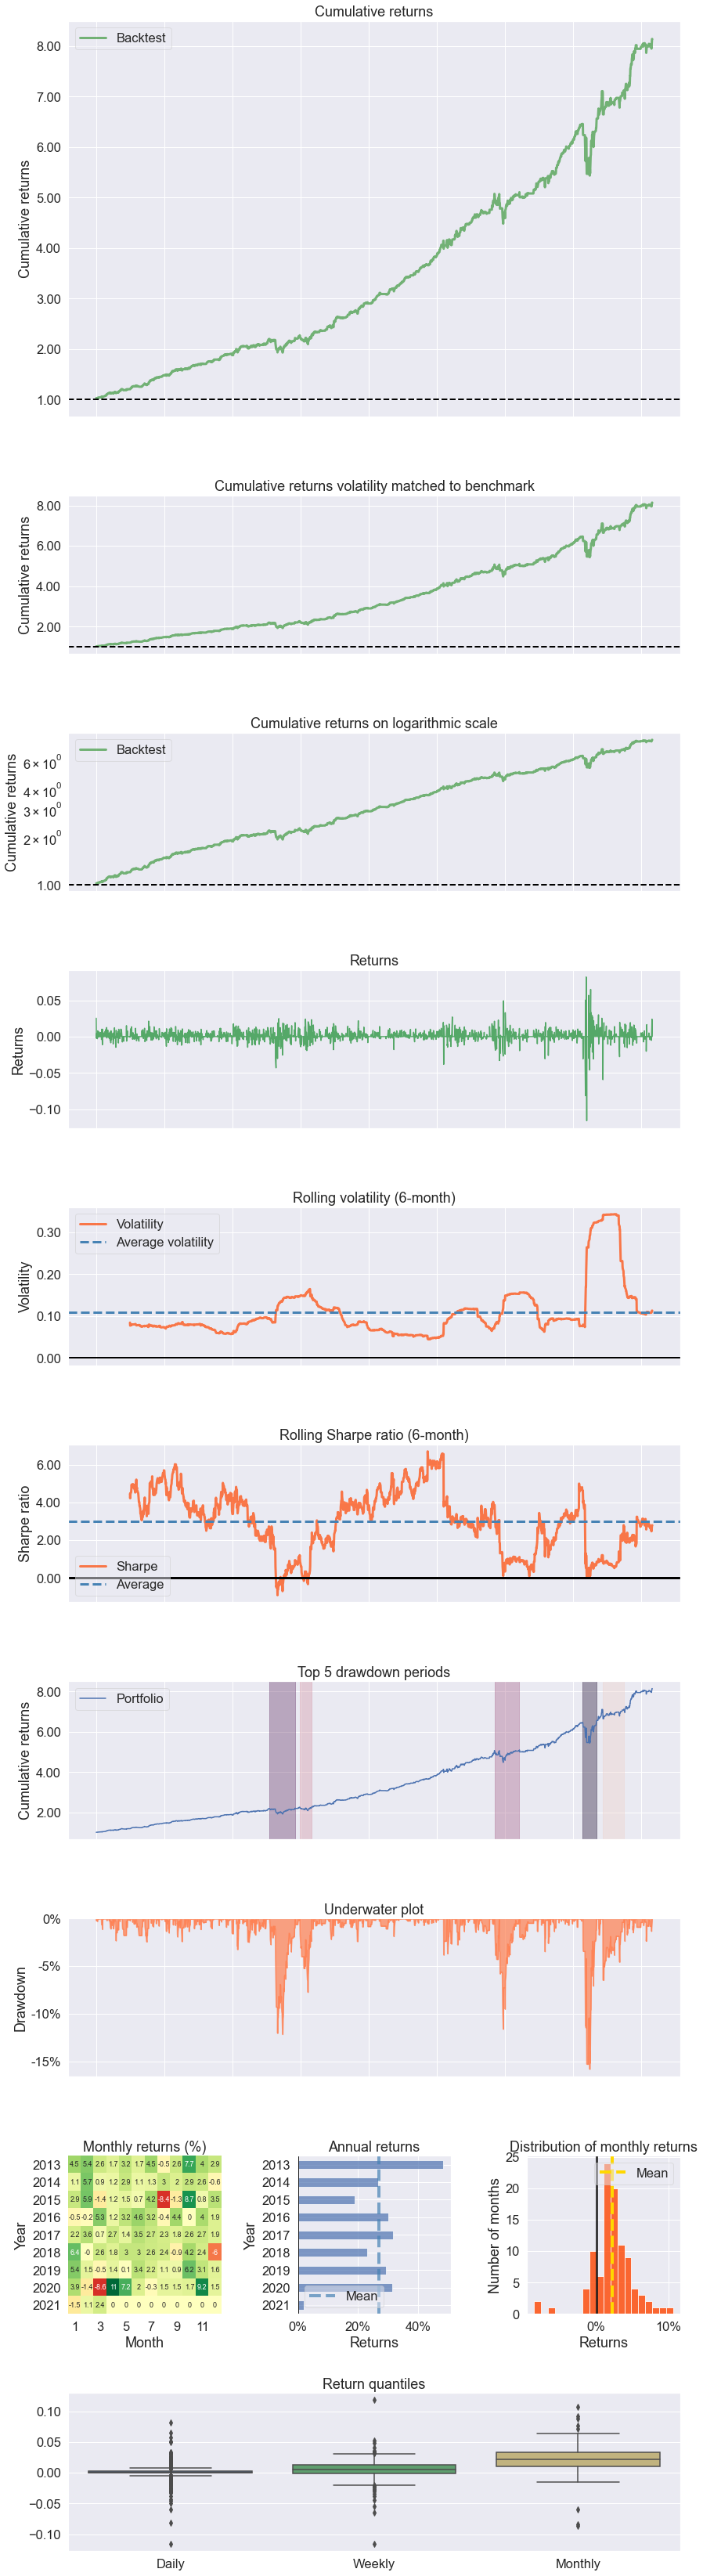

In [49]:
meta_returns = combined_data['Strategy_Returns'].loc['20130102':]
pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)

In [50]:
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.metrics import auc


def crossValPlot(skf,classifier,X_,y_):
    """Code adapted from:
        
    """
    
    X = np.asarray(X_)
    y = np.asarray(y_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))

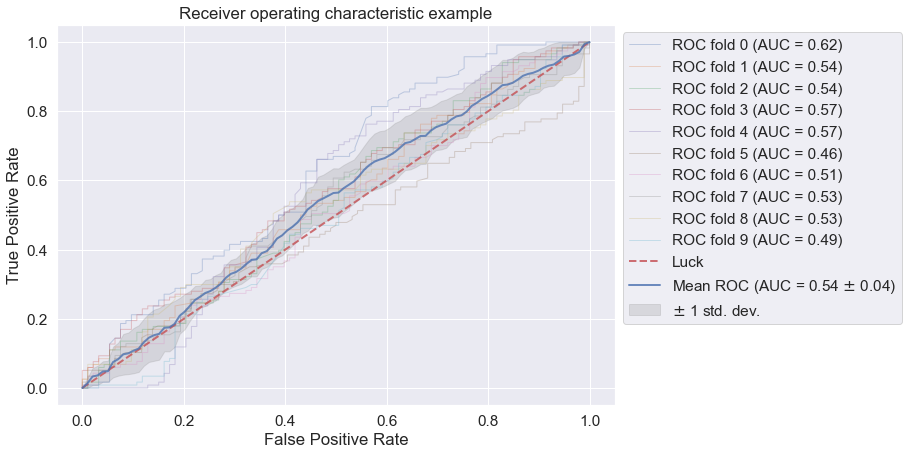

In [52]:
skf = StratifiedKFold(n_splits=10, shuffle=False)
classifier = RandomForestClassifier(n_estimators=10, max_depth=6, 
                                    criterion='entropy',
                                    class_weight='balanced_subsample',
                                    random_state=5)
crossValPlot(skf,classifier,X_test,y_test)

In [53]:
def crossValPlot2(skf,classifier,X,y):
    """Code adapted from:
        
    """
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc
    from scipy import interp
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    idx = pd.IndexSlice
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = (classifier.fit(X.iloc[idx[train]], y.iloc[idx[train]])
                   .predict_proba(X.iloc[idx[test]]))
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[idx[test]], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))

In [54]:
import mlfinlab as ml

In [55]:
combined_data[['SPY']].values <= combined_data[['bb_bbl']].values

array([[False],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [56]:
# Compute sides
combined_data['side'] = np.nan

combined_data['side'] = np.where(combined_data[stock].values <= combined_data[['bb_bbl']].values, 1, -1)

print(combined_data.side.value_counts())
# Remove Look ahead biase by lagging the signal
combined_data['side'] = combined_data['side'].shift(1)

-1    6663
 1     354
Name: side, dtype: int64


In [57]:
# close prices
close = combined_data['SPY']

pt_sl = [1, 2]

daily_vol = ml.util.get_daily_vol(close=close, lookback=50)
cusum_events = ml.filters.cusum_filter(close,
                                       threshold=daily_vol['2011-09-01':'2018-01-01'].mean())
vertical_barriers =  ml.labeling.add_vertical_barrier(t_events=cusum_events,
                                                       close=close, num_days=1)


pt_sl = [1, 2]
min_ret = 0.0005
triple_barrier_events = ml.labeling.get_events(close=close,
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side_prediction=combined_data['side'])

labels =  ml.labeling.get_bins(triple_barrier_events, combined_data['SPY'])
labels.side.value_counts()

2021-03-02 22:38:02.498530 100.0% apply_pt_sl_on_t1 done after 0.11 minutes. Remaining 0.0 minutes.


-1.0    2296
 1.0     162
Name: side, dtype: int64

In [58]:
triple_barrier_events

,t1,trgt,side,pt,sl
1993-04-26,1993-04-27,0.006361,1.0,1,2
1993-04-27,1993-04-28,0.009878,1.0,1,2
1993-05-03,1993-05-04,0.008880,-1.0,1,2
1993-05-13,1993-05-14,0.007860,-1.0,1,2
1993-05-19,1993-05-20,0.009215,-1.0,1,2
...,...,...,...,...,...
2021-02-08,2021-02-09,0.013219,-1.0,1,2
2021-02-22,2021-02-23,0.011612,-1.0,1,2
2021-02-24,2021-02-25,0.011462,-1.0,1,2
2021-02-25,2021-02-26,0.011666,-1.0,1,2


In [59]:
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    Any event that starts before t1[modelcule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

In [60]:
def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

In [61]:
def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

In [62]:
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

In [63]:
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out

In [64]:
def mpSampleW(t1,numCoEvents,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

In [65]:
import multiprocessing as mp
import time

In [ ]:
cpus = 4
close = combined_data[stock]
t1 = triple_barrier_events['t1']
idx = triple_barrier_events.index

numCoEvents = mpPandasObj(mpNumCoEvents,('molecule',idx),cpus, closeIdx=close.index,t1=t1)
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)

sample_weights = pd.DataFrame(index=X_test.index)
sample_weights['w']=mpPandasObj(mpSampleW,('molecule',idx),cpus,
                         t1=t1, numCoEvents=numCoEvents, close=close)
sample_weights['w']*=sample_weights.shape[0]/sample_weights['w'].sum()
cprint(sample_weights)

In [ ]:
from sklearn.model_selection._split import _BaseKFold
class PurgedKFold(_BaseKFold):
    """
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    """
    def __init__(self,n_splits=3,t1=None,pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None)
        self.t1=t1
        self.pctEmbargo=pctEmbargo
        
    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[
            (i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]),
                                                   self.n_splits)
        ]
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j]
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx<X.shape[0]: # right train ( with embargo)
                train_indices=np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

In [ ]:
skf = PurgedKFold(n_splits=10,t1=t1,pctEmbargo=0.01)
classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth,
                                    criterion='entropy', 
                                    class_weight='balanced_subsample',
                                    random_state=RANDOM_STATE)
crossValPlot2(skf,classifier,X,y)


In [ ]:
scores = cvScore(classifier,X_test,y_test,sample_weights['w'],t1=t1,pctEmbargo=0.01,cv=10)
scores = pd.Series(scores).sort_values()
scores